# Demo notebook for XoFTR on a single pair of images
This notebook demonstrates the use of XoFTR with two different data input/output approaches

In [1]:
# Run once
import os
os.chdir("..")
import torch
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from src.utils.plotting import make_matching_figure
%matplotlib inline

## First Approach
Using a data i/o wrapper

In [2]:
from src.xoftr import XoFTR
from src.config.default import get_cfg_defaults
from src.utils.data_io import DataIOWrapper, lower_config

# Get default configurations
config = get_cfg_defaults(inference=True)
config = lower_config(config)

# Coarse level threshold
config['xoftr']['match_coarse']['thr'] = 0.3 # Default 0.3

# Fine level threshold
config['xoftr']['fine']['thr'] = 0.1 # Default 0.1

# It is posseble to get denser matches
# If True, xoftr returns all fine-level matches for each fine-level window (at 1/2 resolution)
config['xoftr']['fine']['denser'] = False # Default False

# XoFTR model
matcher = XoFTR(config=config["xoftr"])

# The input image sizes for xoftr
# Note: The output matches and output images are in original image size
config['test']['img0_resize'] = 640 # resize the longer side, None for no resize
config['test']['img1_resize'] = 640 # resize the longer side, None for no resize

# The path for weights
ckpt = "weights/weights_xoftr_640.ckpt"

# Data I/O wrapper
matcher = DataIOWrapper(matcher, config=config["test"], ckpt=ckpt)

In [ ]:
# Paths for example images
img0_pth = "assets/METU_VisTIR_samples/cloudy/scene_7/visible/images/IM_04525.jpg"
img1_pth = "assets/METU_VisTIR_samples/cloudy/scene_7/thermal/images/IM_01139.jpg"

# Load and match images
# Note: images are converted to grayscale before matching
output_data = matcher.from_paths(img0_pth, img1_pth, read_color=True)

# Matched keypoints
mkpts0 = output_data['mkpts0']
mkpts1 = output_data['mkpts1']

# Confidence values for fine-level matching
mconf = output_data['mconf']

# Original images BGR or GRAY
img0 = output_data['img0']
img1 = output_data['img1']


In [4]:
# Mask outliers using RANSAC (Homography or Fundamental Matrix)

inlier_method = 'F' # F: Fundamental Matrix, H: Homography 

# RANSAC types: https://opencv.org/blog/evaluating-opencvs-new-ransacs/

if inlier_method == 'F':
    F, inlier_mask = cv2.findFundamentalMat(mkpts0, mkpts1, cv2.USAC_MAGSAC, ransacReprojThreshold=1, maxIters=10000, confidence=0.9999)
elif inlier_method == 'H':
    H_pred, inlier_mask = cv2.findHomography(mkpts0, mkpts1, cv2.USAC_MAGSAC, ransacReprojThreshold=1, maxIters=10000, confidence=0.9999)

inlier_mask = inlier_mask.ravel() > 0
mkpts0 = mkpts0[inlier_mask]
mkpts1 = mkpts1[inlier_mask]
mconf = mconf[inlier_mask]

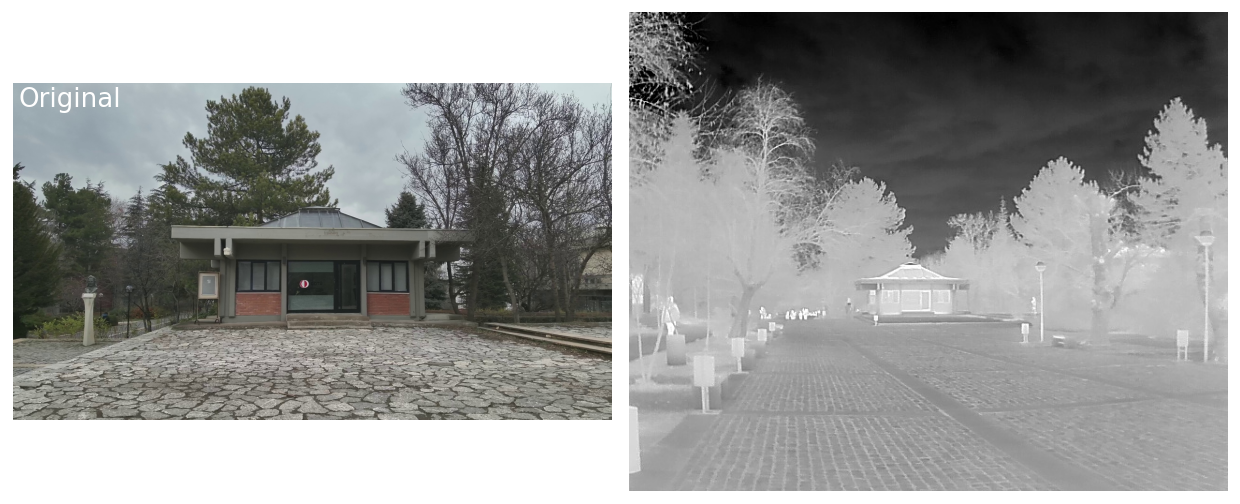

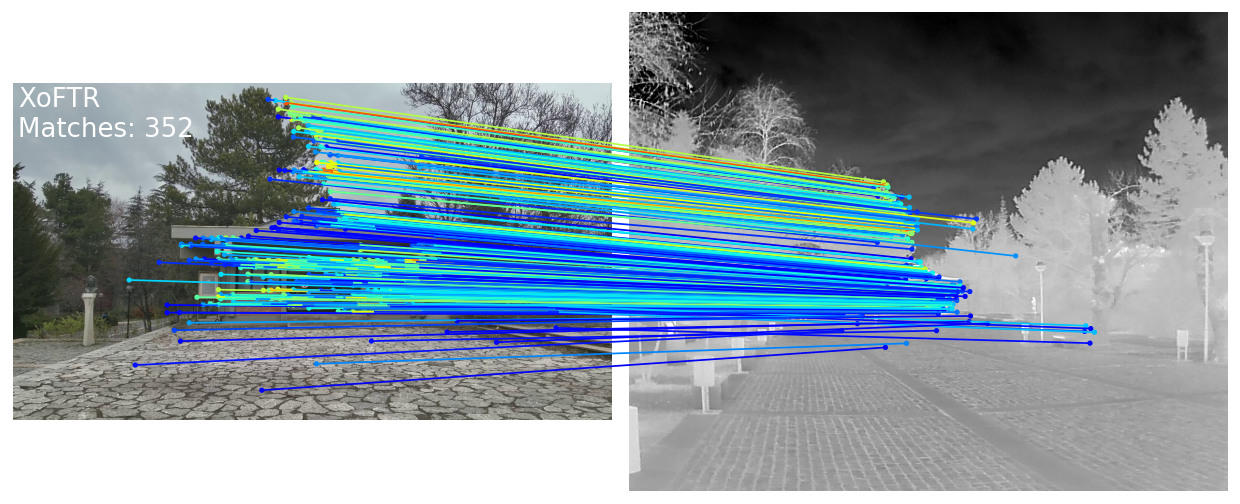

In [5]:
# Draw
color = cm.jet(mconf)
text = [
    'XoFTR',
    'Matches: {}'.format(len(mconf)),
]
if len(img0.shape) == 3:
    _img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
else:
    _img0 = img0
if len(img1.shape) == 3:
    _img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
else:
    _img1 = img1
fig_org = make_matching_figure(_img0, _img1, np.zeros(0),  np.zeros(0),  np.zeros(0), text=["Original"], dpi=125)
fig_match = make_matching_figure(_img0, _img1, mkpts0, mkpts1, color, text=text, dpi=125)

## Second Approach
Process inputs and outputs manually

In [6]:
from src.xoftr import XoFTR
from src.config.default import get_cfg_defaults
from src.utils.misc import lower_config
from src.utils.data_io import DataIOWrapper

# Get default configurations
config = get_cfg_defaults(inference=True)
config = lower_config(config)

# Coarse level threshold
config['xoftr']['match_coarse']['thr'] = 0.3 # Default 0.3

# Fine level threshold
config['xoftr']['fine']['thr'] = 0.1 # Default 0.1

# It is posseble to get denser matches
# If True, xoftr returns all fine-level matches for each fine-level window (at 1/2 resolution)
config['xoftr']['fine']['denser'] = False # Default False

# XoFTR model
matcher = XoFTR(config=config["xoftr"])

# The path for weights
ckpt = "weights/weights_xoftr_640.ckpt"

# Load model
matcher.load_state_dict(torch.load(ckpt)['state_dict'],strict=True)
matcher = matcher.eval().cuda()

In [7]:
# Paths for example images
img0_pth = "assets/METU_VisTIR_samples/indoor/scene_8/visible/images/IM_02798.jpg"
img1_pth = "assets/METU_VisTIR_samples/indoor/scene_8/thermal/images/IM_00006.jpg"

# Read images
img0_raw = cv2.imread(img0_pth)
img1_raw = cv2.imread(img1_pth)

print("Image 0 shape:", img0_raw.shape)
print("Image 1 shape:", img1_raw.shape)

Image 0 shape: (2160, 3840, 3)
Image 1 shape: (512, 640, 3)


In [8]:

# Change the sizes of the images
img0_size = (640, 360) # input size shuold be divisible by 8
img1_size = (640, 512) # input size shuold be divisible by 8

# Or the sizes remains the same
# img0_size = (img0_raw.shape[1], img0_raw.shape[0]) 
# img1_size = (img1_raw.shape[1], img1_raw.shape[0]) 

# Resize images
img0_raw = cv2.resize(img0_raw, (img0_size[0]//8*8, img0_size[1]//8*8))  
img1_raw = cv2.resize(img1_raw, (img1_size[0]//8*8, img1_size[1]//8*8)) 

# Convert images to gray and tensor
img0 = torch.from_numpy(cv2.cvtColor(img0_raw, cv2.COLOR_BGR2GRAY))[None][None].cuda() / 255.
img1 = torch.from_numpy(cv2.cvtColor(img1_raw, cv2.COLOR_BGR2GRAY))[None][None].cuda() / 255.
batch = {'image0': img0, 'image1': img1}

# Inference with XoFTR and get prediction
with torch.no_grad():
    matcher(batch)
    mkpts0 = batch['mkpts0_f'].cpu().numpy()
    mkpts1 = batch['mkpts1_f'].cpu().numpy()
    mconf = batch['mconf_f'].cpu().numpy()

In [9]:
# Mask outliers using RANSAC (Homography or Fundamental Matrix)

inlier_method = 'F' # F: Fundamental Matrix, H: Homography 

if inlier_method == 'F':
    F, inlier_mask = cv2.findFundamentalMat(mkpts0, mkpts1, cv2.USAC_MAGSAC, ransacReprojThreshold=1, maxIters=10000, confidence=0.9999)
elif inlier_method == 'H':
    H_pred, inlier_mask = cv2.findHomography(mkpts0, mkpts1, cv2.USAC_MAGSAC, ransacReprojThreshold=1, maxIters=10000, confidence=0.9999)

inlier_mask = inlier_mask.ravel() > 0
mkpts0 = mkpts0[inlier_mask]
mkpts1 = mkpts1[inlier_mask]
mconf = mconf[inlier_mask]

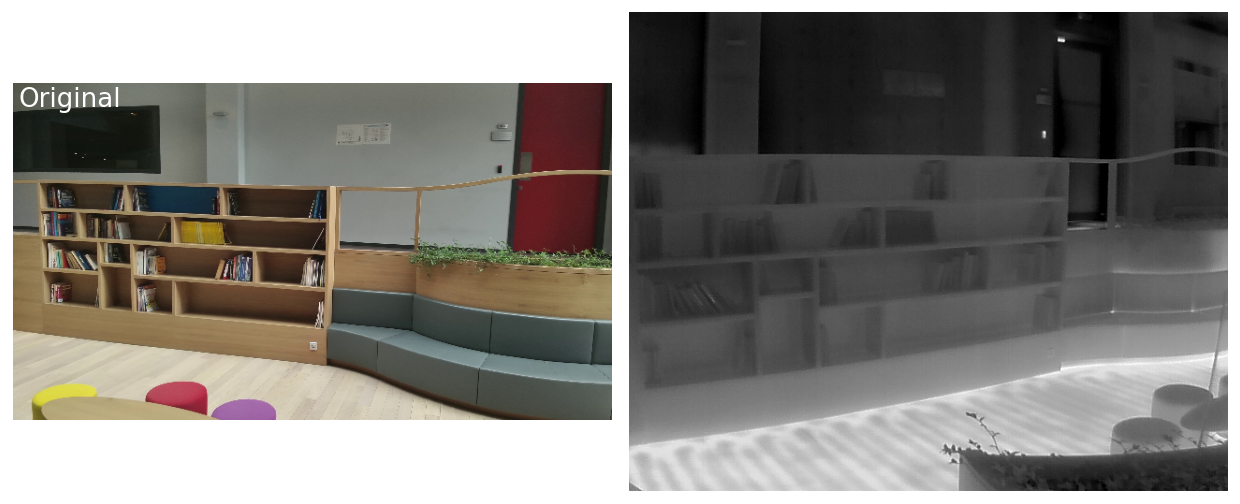

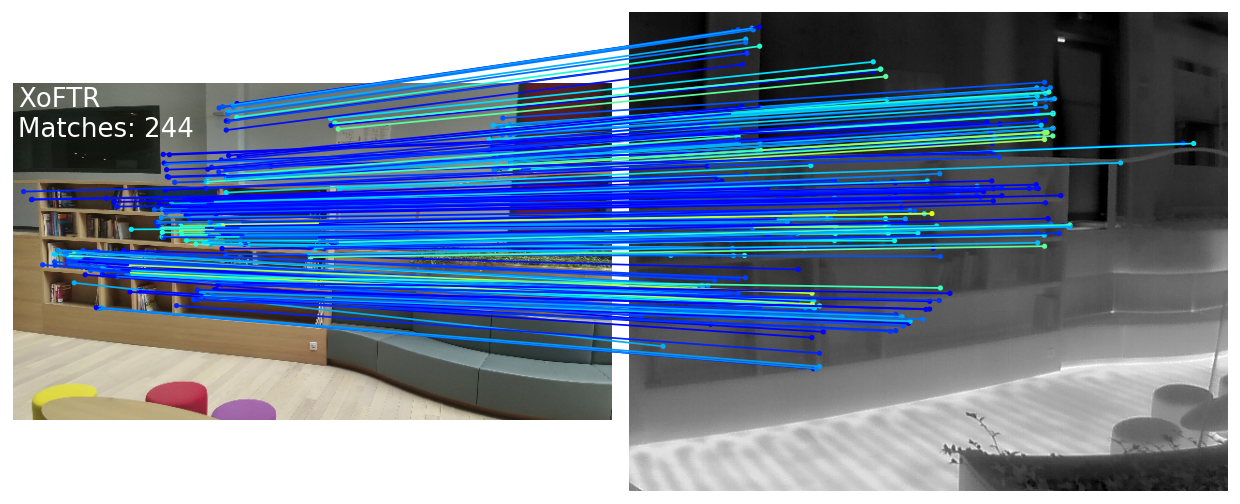

In [10]:
# Draw
color = cm.jet(mconf)
text = [
    'XoFTR',
    'Matches: {}'.format(len(mconf)),
]
if len(img0_raw.shape) == 3:
    _img0 = cv2.cvtColor(img0_raw, cv2.COLOR_BGR2RGB)
else:
    _img0 = img0_raw
if len(img1_raw.shape) == 3:
    _img1 = cv2.cvtColor(img1_raw, cv2.COLOR_BGR2RGB)
else:
    _img1 = img1_raw
fig_org = make_matching_figure(_img0, _img1, np.zeros(0),  np.zeros(0),  np.zeros(0), text=["Original"], dpi=125)
fig_match = make_matching_figure(_img0, _img1, mkpts0, mkpts1, color, text=text, dpi=125)